In [16]:
# import numpy, scipy, and matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
%matplotlib widget

import os
import tempfile

# torch random seed
torch.manual_seed(0)

# Lorenz PINN baseline
In this notebook we apply the same method as the DHO baseline to the Lorenz system. After some preliminary test, here we show what append if we limit the train time span between (0,0.25) training the short_lorenz_baseline. In a second part we will train the long_lorenz_baseline with the time span (0,1).

## Useful func

In [17]:
def lorenz(t, Y):
    """
    This function returns the right-hand side of the Lorenz system of ordinary differential equations.
    Parameters:
    t (float): time
    Y (array): state vector [x, y, z]

    Returns:
    array: [dxdt, dydt, dzdt]
    """

    x, y, z = Y
    dxdt = 10 * (y - x)
    dydt = x * (28 - z) - y
    dzdt = x * y - 8/3 * z

    return [dxdt, dydt, dzdt]


def seq_lorenz(Y):
    """
    This function returns the right-hand side of the Lorenz system of ordinary differential equations.
    Parameters:
    Y (array): state vector [x, y, z]

    Returns:
    array: [dxdt, dydt, dzdt]
    """

    x, y, z = Y[:, 0], Y[:, 1], Y[:, 2]
    dxdt = 10 * (y - x)
    dydt = x * (28 - z) - y
    dzdt = x * y - 8/3 * z

    return np.array([dxdt, dydt, dzdt]).T

In [18]:
def plot_components(X, Y):
    """
    This function plots the components of the state vector Y as a function of time X.
    """
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(X, Y[:,0], label='x')
    plt.ylabel('x')
    plt.xlabel('time')
    plt.grid()

    # do all the same for y
    plt.subplot(132)
    plt.plot(X, Y[:,1], label='y')
    plt.ylabel('y')
    plt.xlabel('time')
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(X, Y[:,2], label='z')
    plt.ylabel('z')
    plt.xlabel('time')
    plt.grid()



def plot_compare_components(X, Y, Y_pred):
    """
    This function plots the components of the state vector Y and Y_pred as a function of time X.
    """
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(X, Y[:,0], label='x')
    plt.plot(X, Y_pred[:,0], label='x_pred')
    plt.ylabel('x')
    plt.xlabel('time')
    plt.legend()
    plt.grid()

    # do all the same for y
    plt.subplot(132)
    plt.plot(X, Y[:,1], label='y')
    plt.plot(X, Y_pred[:,1], label='y_pred')
    plt.ylabel('y')
    plt.xlabel('time')
    plt.legend()
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(X, Y[:,2], label='z')
    plt.plot(X, Y_pred[:,2], label='z_pred')
    plt.ylabel('z')
    plt.xlabel('time')
    plt.legend()
    plt.grid()


def show_history(history, name=None):
    """
    This function plots the loss and learning rate as a function of epoch.
    """
    history = np.array(history)
    fig, ax = plt.subplots(figsize=(15, 10))

    # plot the loss
    ax.plot(history[:, 0], label='loss')
    ax.legend(loc='upper left')
    ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.grid()

    # plot the learning rate
    ax2 = ax.twinx()
    ax2.plot(history[:, -1], label='lr', color='r')
    ax2.set_yscale('log')
    ax2.set_ylabel('lr')
    # legend to the right
    ax2.legend(loc='upper right')
    plt.grid()
    plt.title('history' + name)

    # history to list
    history = history.tolist()

    

# def a function called ode_loss
def lorenz_loss_ode(model, X):
    """
    This function calculates the loss of the ode for the Lorenz system
    as a function of the input tensor X (time).
    Parameters:
    model (torch.nn.Module): the model
    X (torch.tensor): the input tensor
    """

    X.requires_grad = True
    Y_pred = model(X)

    # get the derivatives
    dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
    dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
    dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode = 20 * (Y_pred[:,1] - Y_pred[:,0])
    dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
    dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

    # loss ode
    loss_ode = (dx_dt_pred[:,0]- dx_dt_ode)**2 + (dy_dt_pred[:,0]- dy_dt_ode)**2 + (dz_dt_pred[:,0]- dz_dt_ode)**2

    return loss_ode



def plot_propagation(X, Y_true, Y_pred, Y0_index):
    """
    This function compare predicted and true solution of the lorenz system,
    in addition there is the solution (with solve_ivp) propagated from the predicted state at the Y0_index.
    Parameters:
    X (array): time
    Y_true (array): true state
    Y_pred (array): predicted state
    Y0_index (int): index of the predicted state to be used as initial condition
    """

    # get the predicted state for the maximum index
    Y0 = Y_pred[Y0_index]

    # evove with the lorenz function, use scipy ivp_solve
    sol = sp.integrate.solve_ivp(lorenz, [X[Y0_index], 1], Y0, t_eval=X[Y0_index:])

    # plot the solution
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(sol.t, sol.y[0], label='x_prop', marker='o')
    # plot the predicted solution
    plt.plot(X, Y_pred[:,0], label='x_pred')
    # plot x real
    plt.plot(X, Y_true[:,0], label='x_real')
    # red dot in the maximum index
    plt.plot(X[Y0_index], Y_pred[Y0_index,0], 'ro')
    plt.ylabel('x')
    plt.xlabel('t')
    plt.grid()
    plt.legend()

    # do all the same for y
    plt.subplot(132)
    plt.plot(sol.t, sol.y[1], label='y_prop', marker='o')
    plt.plot(X, Y_pred[:,1], label='y_pred')
    plt.plot(X, Y_true[:,1], label='y_real')
    plt.plot(X[Y0_index], Y_pred[Y0_index,1], 'ro')
    plt.ylabel('y')
    plt.xlabel('t')
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(sol.t, sol.y[2], label='z_prop', marker='o')
    plt.plot(X, Y_pred[:,2], label='z_pred')
    plt.plot(X, Y_true[:,2], label='z_real')
    plt.plot(X[Y0_index], Y_pred[Y0_index,2], 'ro')
    plt.ylabel('z')
    plt.xlabel('t')
    plt.grid()

## Load data

In [19]:
# import data
# data are generated by "src/DHOscillator_data_gen.py"
data = np.load('../data/Lorenz_data.npy')
# Y is the state, X is the time, Y is made of x, y, z
X = data[:,0]
Y = data[:,1:]

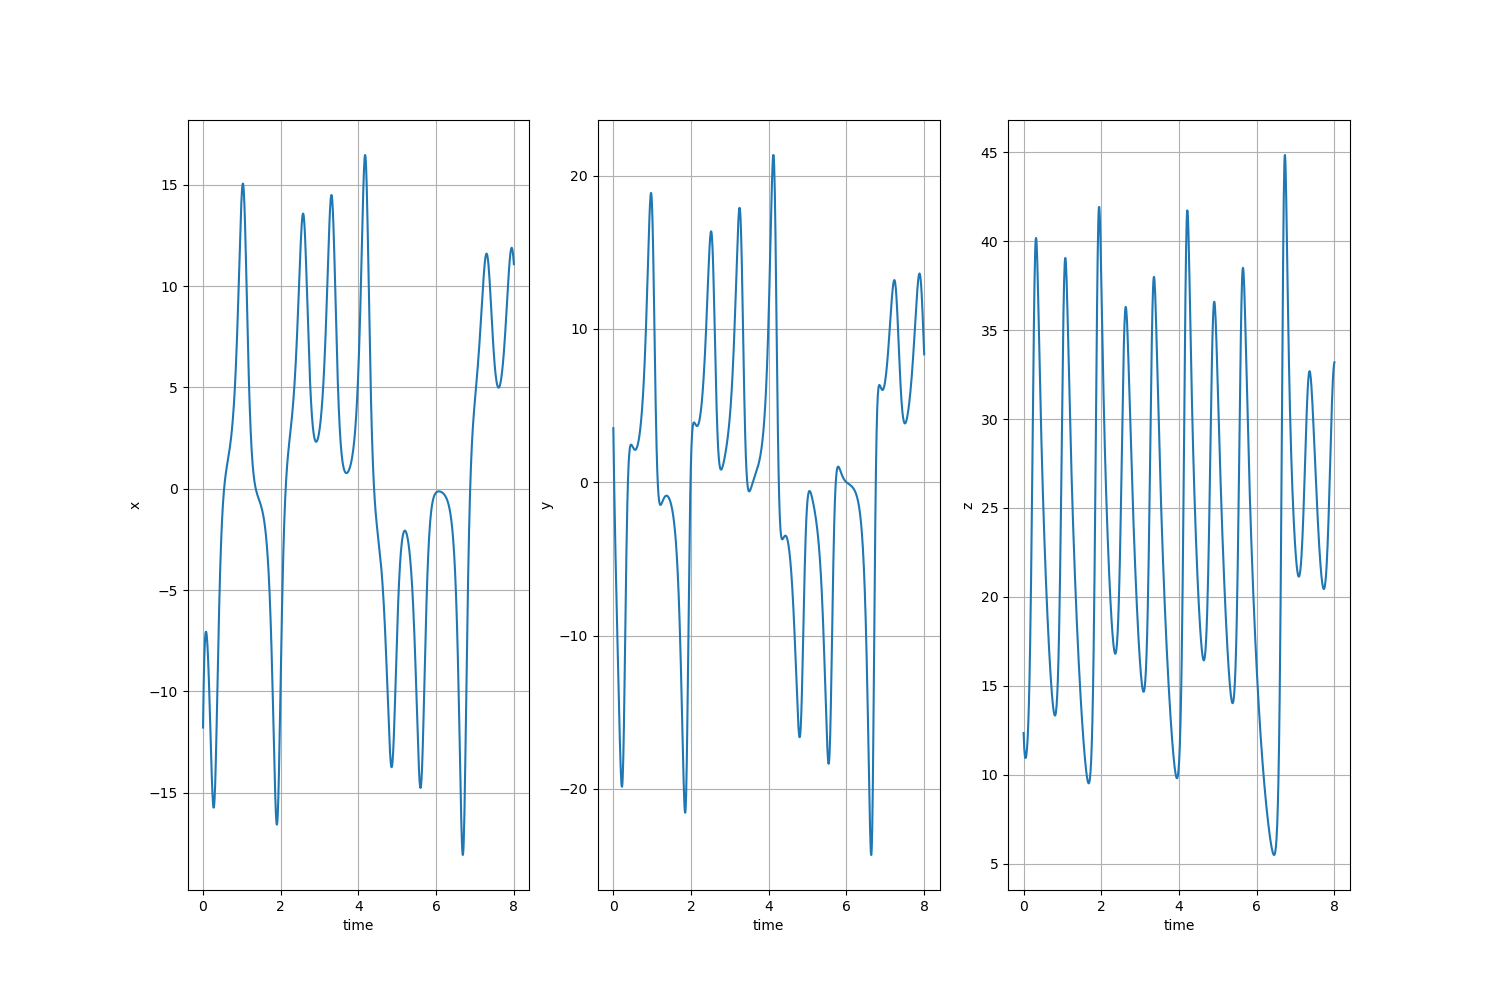

In [20]:
# plot components
plot_components(X, Y)

## Define the model
This is inspired by the tuned model on DHO

In [21]:
# Model class
class FFNN(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FFNN, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(torch.nn.Linear(1, n_neurons))
            else:
                layers.append(torch.nn.Linear(n_neurons, n_neurons))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(n_neurons, 3))
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [22]:
n_layers = 4
n_neurons = 28
n_epochs = 10000
# create model
short_model = FFNN(n_layers, n_neurons)

## Short model 

In [23]:
history_PINN = []

In [24]:
# define the optimizer
optimizer = torch.optim.Adam(short_model.parameters(), lr=0.001)
# add minimun to lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=1000, min_lr=1e-5)

# define the loss function, L2
loss_fn = torch.nn.MSELoss()


In [25]:
# select only time < 2
X_sub = X[X<0.26]
Y_sub = Y[X<0.26]

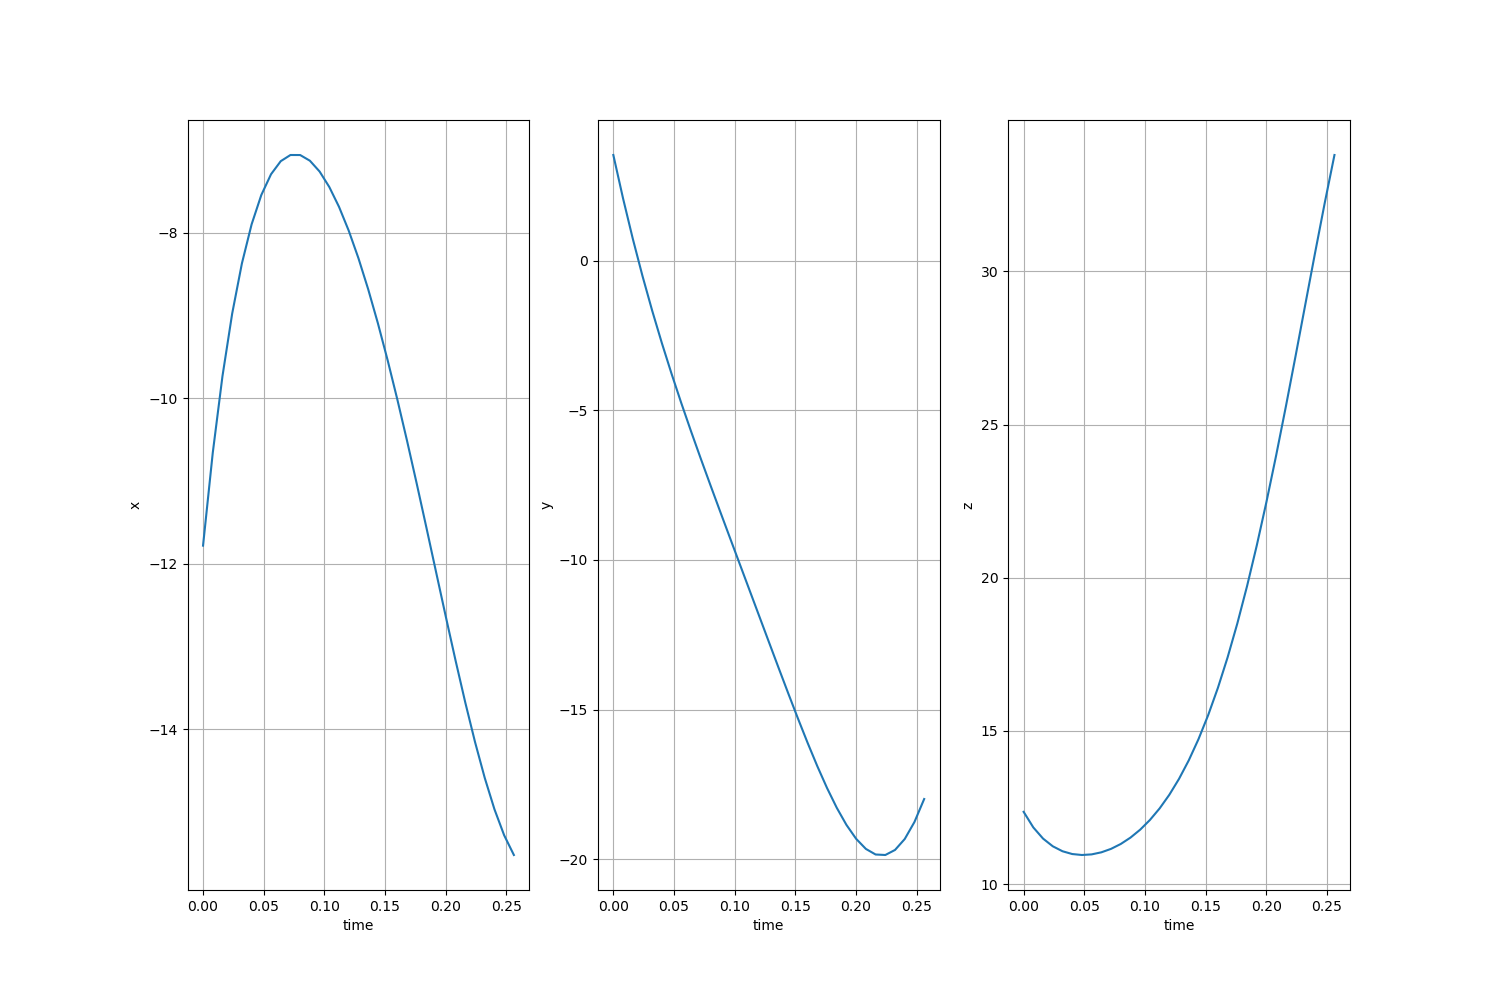

In [26]:
# plot components
plot_components(X_sub, Y_sub)

In [27]:
# to torch
X_sub_t = torch.tensor(X_sub, dtype=torch.float32).view(-1, 1)
Y_sub_t = torch.tensor(Y_sub, dtype=torch.float32)


3*250000

In [38]:
%%time

for epoch in range(3*250000):
    optimizer.zero_grad()
    X_sub_t.requires_grad = True
    Y_pred = short_model(X_sub_t)

    # get the derivatives
    dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
    dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
    dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode = 10 * (Y_pred[:,1] - Y_pred[:,0])
    dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
    dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

    # loss ode
    loss_ode = loss_fn(dx_dt_pred[:,0], dx_dt_ode) + loss_fn(dy_dt_pred[:,0], dy_dt_ode) + loss_fn(dz_dt_pred[:,0], dz_dt_ode)

    # add loss ic
    loss_ic = torch.mean((Y_pred[0] - Y_sub_t[0])**2)

    loss = 20*loss_ode + loss_ic

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    history_PINN.append([loss.item(), loss_ode.detach().numpy(), loss_ic.detach().numpy(), optimizer.param_groups[0]["lr"]])    

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}, lr {optimizer.param_groups[0]["lr"]}')

Epoch 0, Loss 0.26342737674713135, lr 0.0004096000000000001
Epoch 1000, Loss 0.484549343585968, lr 0.0004096000000000001
Epoch 2000, Loss 0.2737593352794647, lr 0.0004096000000000001
Epoch 3000, Loss 0.3397865891456604, lr 0.0004096000000000001
Epoch 4000, Loss 0.2481081336736679, lr 0.0004096000000000001
Epoch 5000, Loss 0.26107338070869446, lr 0.0004096000000000001
Epoch 6000, Loss 0.6151490807533264, lr 0.0004096000000000001
Epoch 7000, Loss 0.310327410697937, lr 0.0004096000000000001
Epoch 8000, Loss 0.41346481442451477, lr 0.0004096000000000001
Epoch 9000, Loss 0.23382900655269623, lr 0.0004096000000000001
Epoch 10000, Loss 0.8320176005363464, lr 0.0004096000000000001
Epoch 11000, Loss 0.25102561712265015, lr 0.0004096000000000001
Epoch 12000, Loss 0.35422852635383606, lr 0.0004096000000000001
Epoch 13000, Loss 0.25925007462501526, lr 0.0004096000000000001
Epoch 14000, Loss 0.5006727576255798, lr 0.0004096000000000001
Epoch 15000, Loss 0.542710542678833, lr 0.0004096000000000001
E

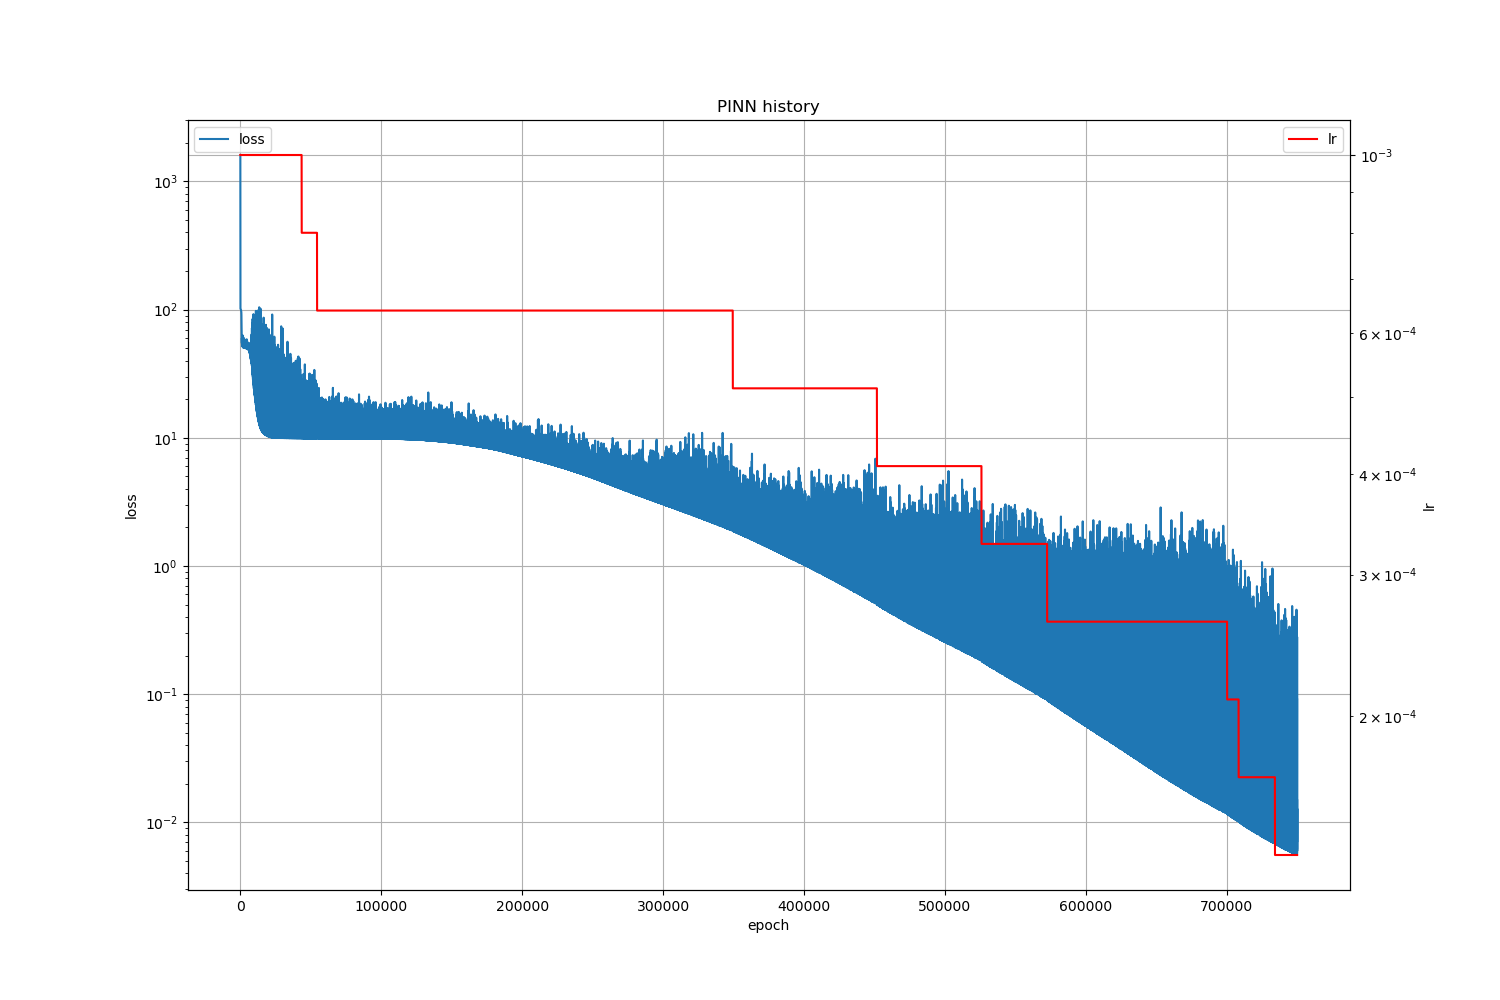

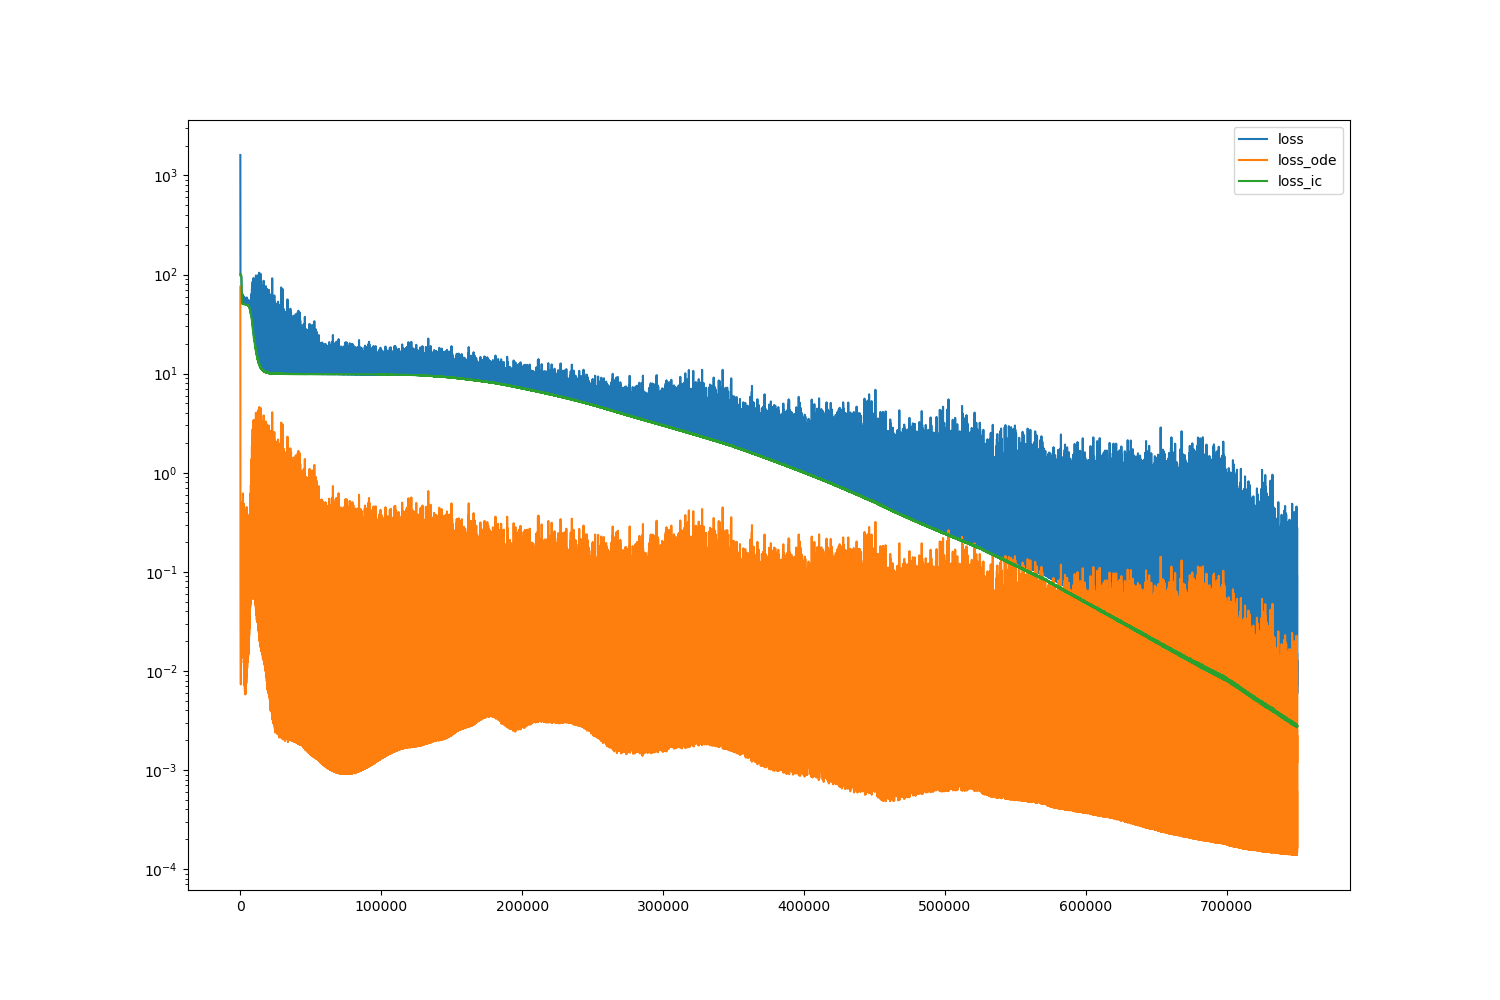

In [39]:
# plot history_PINN loss and lr in two subplots
history_PINN = np.array(history_PINN)

fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history_PINN[:, 0], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history_PINN[:, -1], label='lr', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('PINN history')


# plot losses
plt.figure(figsize=(15, 10))
plt.plot(history_PINN[:, 0], label='loss')
plt.plot(history_PINN[:, 1], label='loss_ode')
plt.plot(history_PINN[:, 2], label='loss_ic')
plt.legend()
plt.yscale('log')

# history to list
history_PINN = history_PINN.tolist()

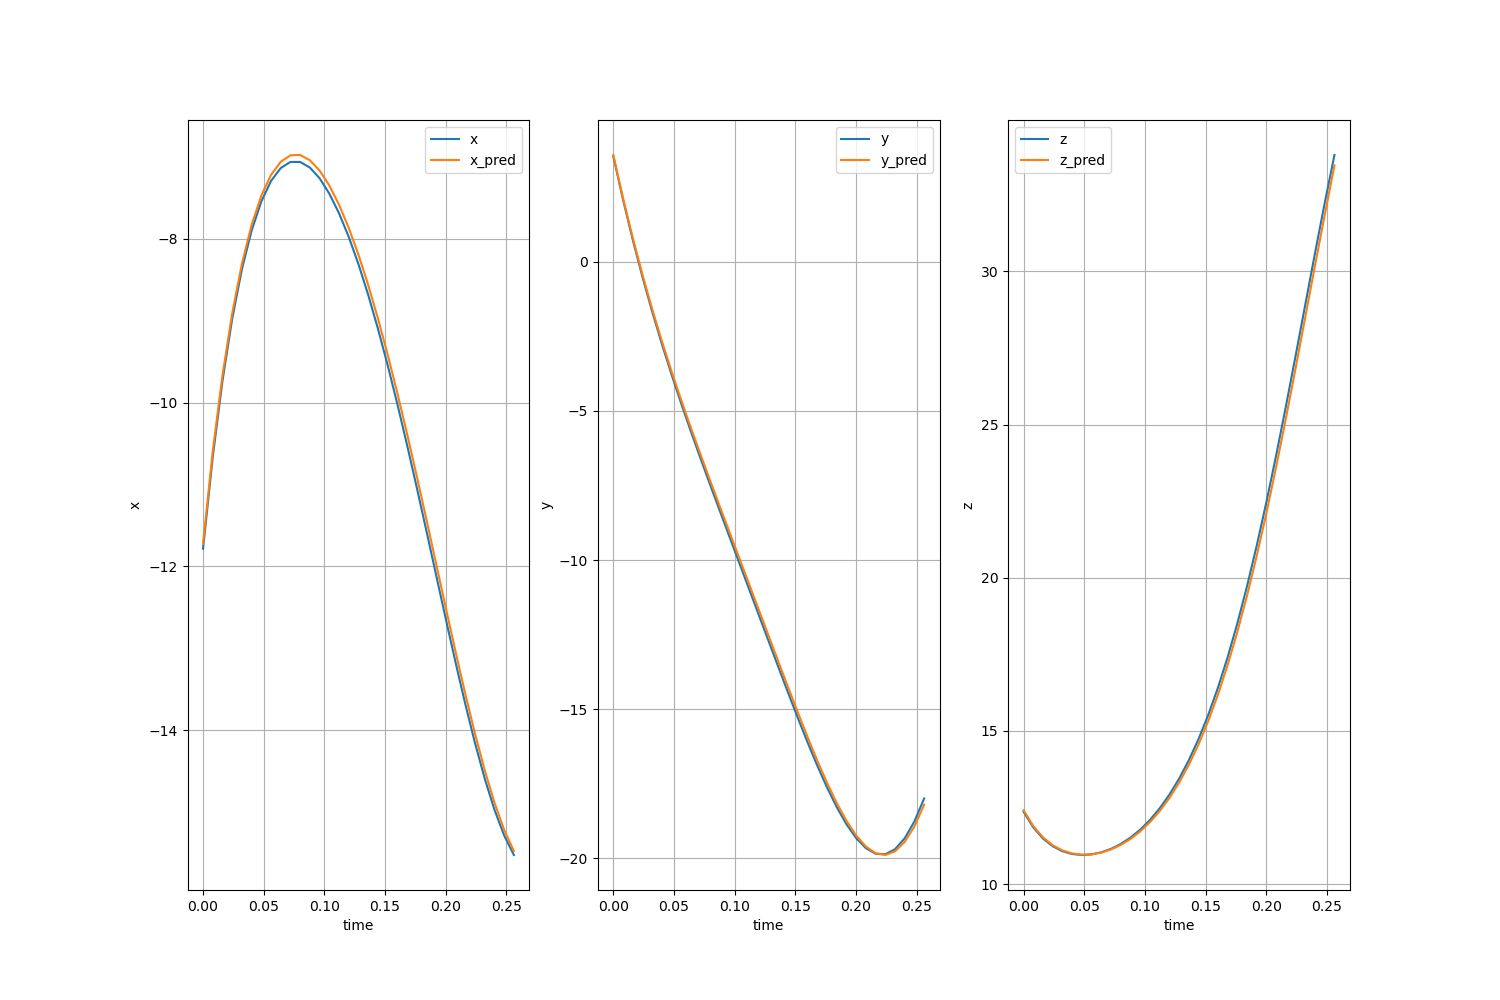

In [40]:
# get prediction and plot compare
Y_pred = short_model(X_sub_t).detach().numpy()
plot_compare_components(X_sub, Y_sub, Y_pred)

In [ ]:
# save model in ../models/Lorenz_PINN_baseline/Lorenz_short_baseline.pt
## torch.save(short_model, '../models/Lorenz_PINN_baseline/Lorenz_short_baseline.pt')

## Long model
Starting with the same model, already trained on the short time span, we will train the model on the time span (0,1). Note that the epochs are 3x the short model.

In [42]:
# define the optimizer
optimizer = torch.optim.Adam(short_model.parameters(), lr=0.001)
# add minimun to lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=1000, min_lr=1e-5)

# define the loss function, L2
loss_fn = torch.nn.MSELoss()


In [56]:
# select only time < 2
X_sub = X[X<1]
Y_sub = Y[X<1]

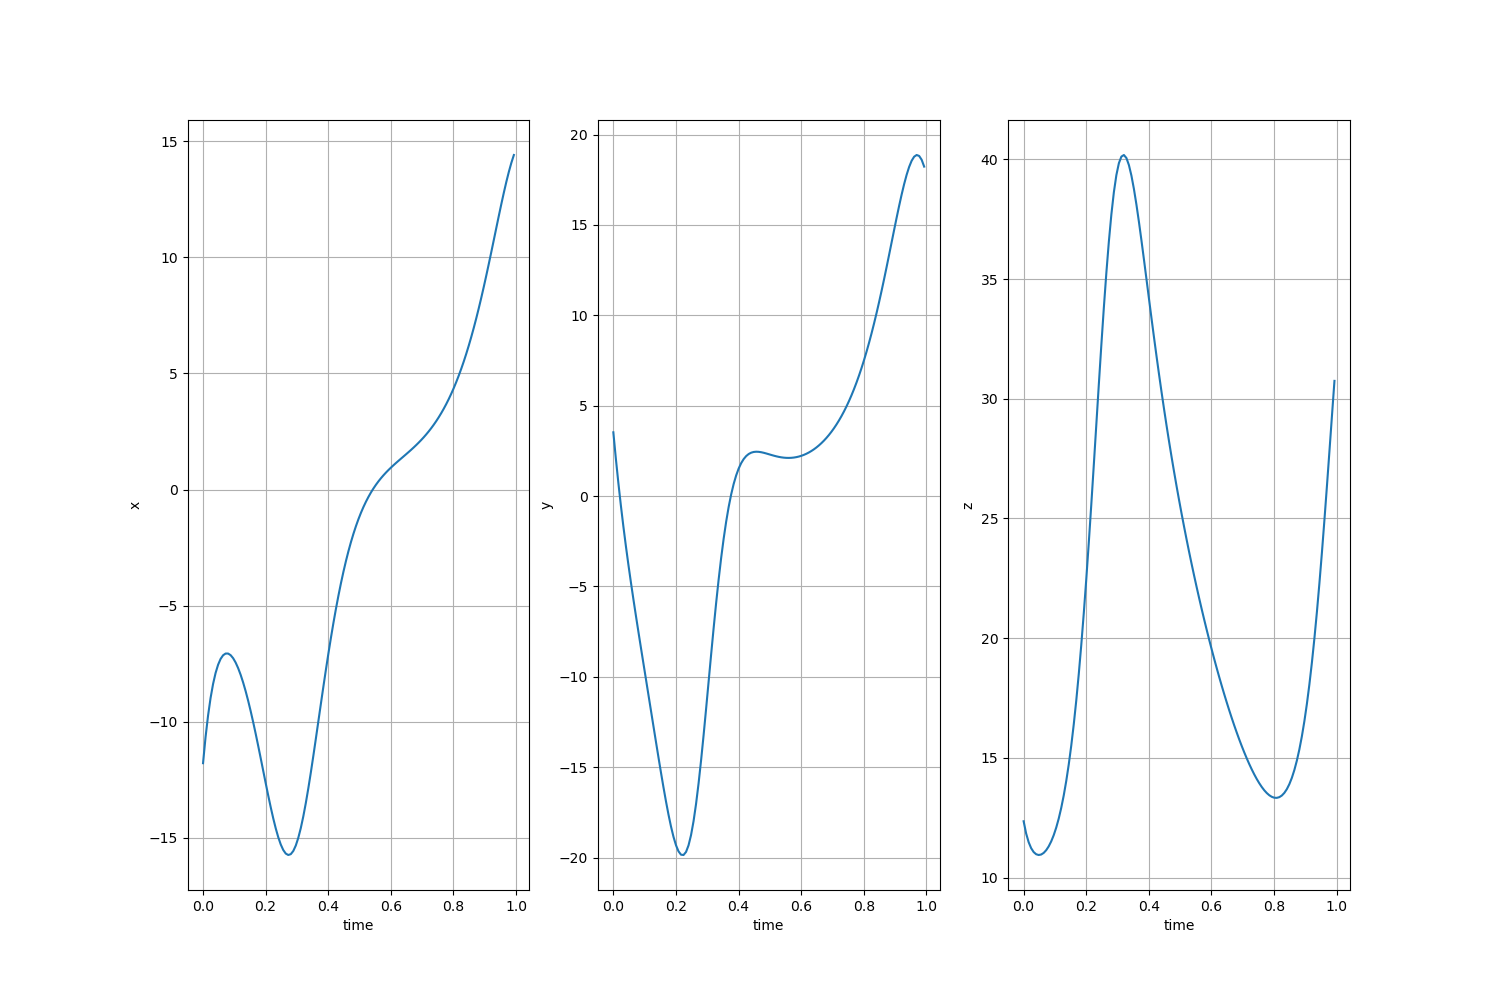

In [57]:
# plot components
plot_components(X_sub, Y_sub)

In [58]:
# to torch
X_sub_t = torch.tensor(X_sub, dtype=torch.float32).view(-1, 1)
Y_sub_t = torch.tensor(Y_sub, dtype=torch.float32)


In [46]:
%%time

for epoch in range(9*250000):
    optimizer.zero_grad()
    X_sub_t.requires_grad = True
    Y_pred = short_model(X_sub_t)

    # get the derivatives
    dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
    dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
    dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode = 10 * (Y_pred[:,1] - Y_pred[:,0])
    dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
    dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

    # loss ode
    loss_ode = loss_fn(dx_dt_pred[:,0], dx_dt_ode) + loss_fn(dy_dt_pred[:,0], dy_dt_ode) + loss_fn(dz_dt_pred[:,0], dz_dt_ode)

    # add loss ic
    loss_ic = torch.mean((Y_pred[0] - Y_sub_t[0])**2)

    loss = 20*loss_ode + loss_ic

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    history_PINN.append([loss.item(), loss_ode.detach().numpy(), loss_ic.detach().numpy(), optimizer.param_groups[0]["lr"]])    

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}, lr {optimizer.param_groups[0]["lr"]}')

Epoch 0, Loss 626389.5, lr 0.001
Epoch 1000, Loss 145.3151092529297, lr 0.001
Epoch 2000, Loss 125.38775634765625, lr 0.001
Epoch 3000, Loss 119.87185668945312, lr 0.001
Epoch 4000, Loss 111.70367431640625, lr 0.001
Epoch 5000, Loss 104.68612670898438, lr 0.001
Epoch 6000, Loss 99.33305358886719, lr 0.001
Epoch 7000, Loss 85.5203857421875, lr 0.001
Epoch 8000, Loss 82.61097717285156, lr 0.001
Epoch 9000, Loss 80.74768829345703, lr 0.001
Epoch 10000, Loss 81.3205795288086, lr 0.001
Epoch 11000, Loss 74.30023193359375, lr 0.001
Epoch 12000, Loss 68.00859832763672, lr 0.001
Epoch 13000, Loss 59.172706604003906, lr 0.001
Epoch 14000, Loss 51.27915573120117, lr 0.001
Epoch 15000, Loss 40.913787841796875, lr 0.001
Epoch 16000, Loss 33.425106048583984, lr 0.001
Epoch 17000, Loss 27.24936866760254, lr 0.001
Epoch 18000, Loss 22.314571380615234, lr 0.001
Epoch 19000, Loss 18.15882682800293, lr 0.001
Epoch 20000, Loss 16.817596435546875, lr 0.001
Epoch 21000, Loss 11.265545845031738, lr 0.001
Ep

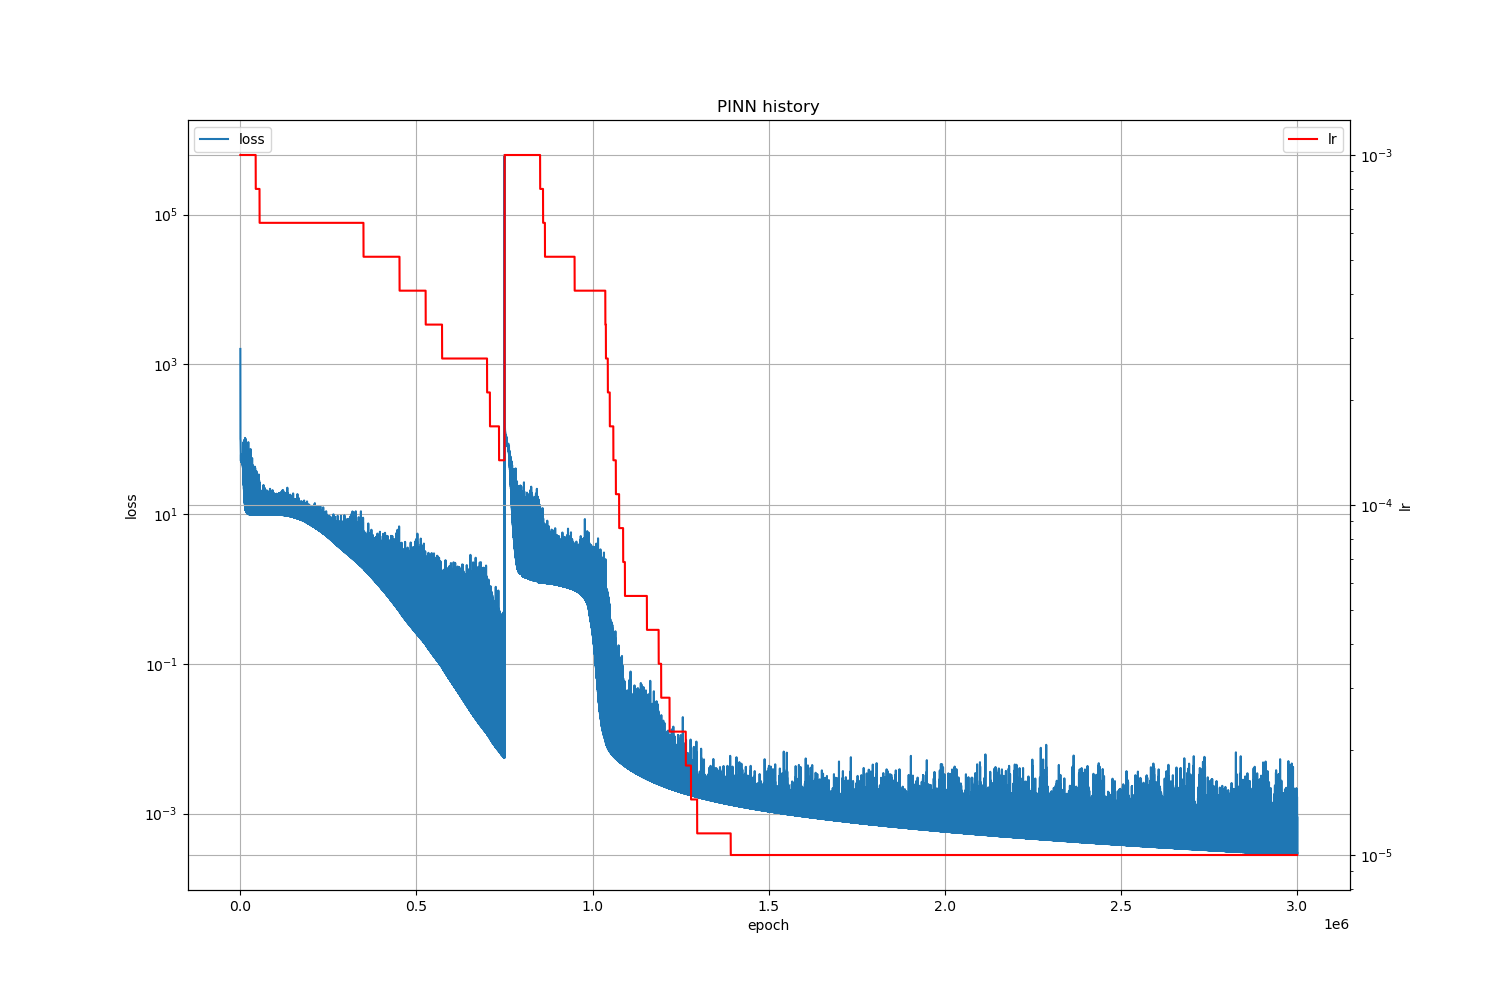

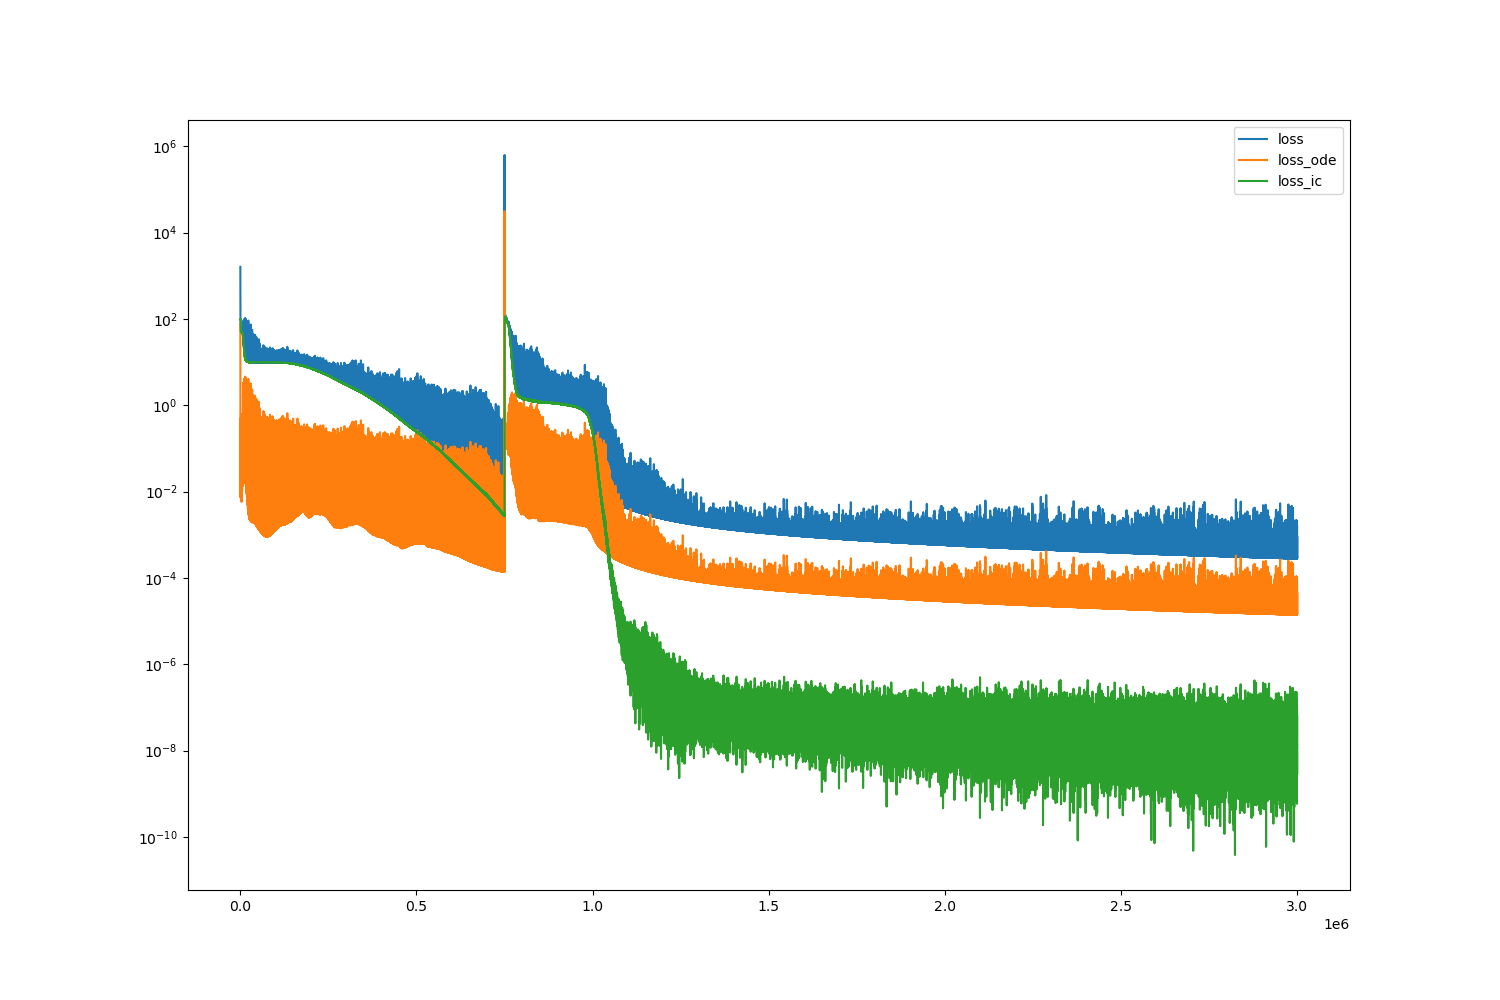

In [77]:
# plot history_PINN loss and lr in two subplots
history_PINN = np.array(history_PINN)

fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history_PINN[:, 0], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history_PINN[:, -1], label='lr', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('PINN history')
# save fig
plt.savefig('../plot/lorenz_long_hostory.pdf')


# plot losses
plt.figure(figsize=(15, 10))
plt.plot(history_PINN[:, 0], label='loss')
plt.plot(history_PINN[:, 1], label='loss_ode')
plt.plot(history_PINN[:, 2], label='loss_ic')
plt.legend()
plt.yscale('log')

# history to list
history_PINN = history_PINN.tolist()


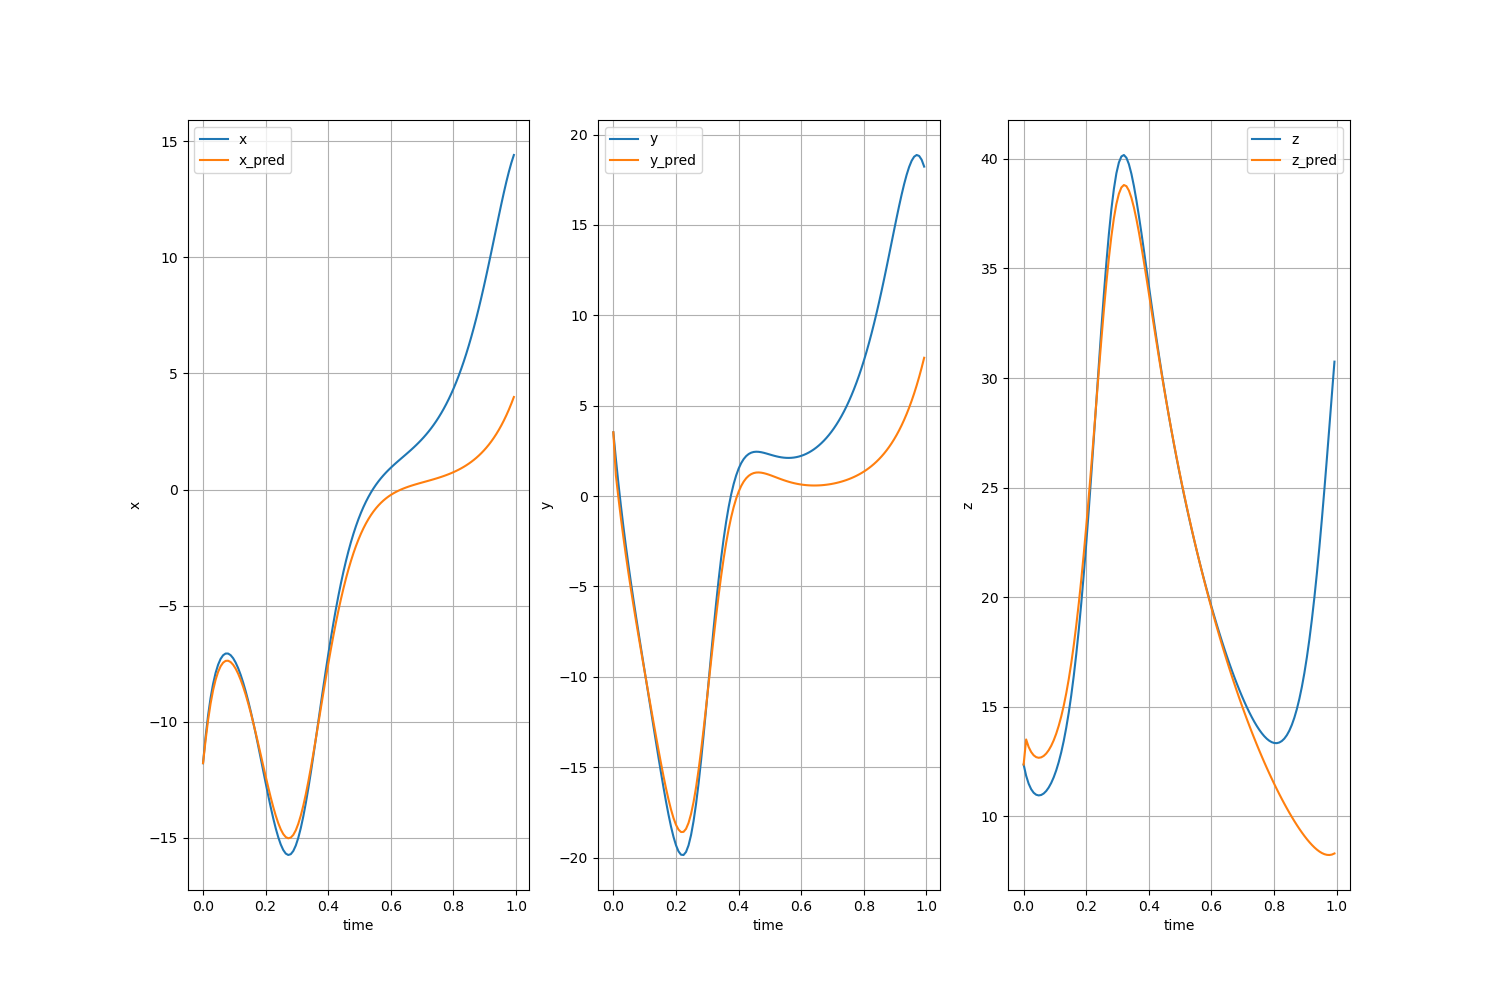

In [48]:
# get prediction and plot compare
Y_pred = short_model(X_sub_t).detach().numpy()
plot_compare_components(X_sub, Y_sub, Y_pred)

In [ ]:
# save model in ../models/Lorenz_PINN_baseline/Lorenz_long_baseline.pt
## torch.save(short_model, '../models/Lorenz_PINN_baseline/Lorenz_long_baseline.pt')